# **📘 1. ¿Qué mide el AQI tradicional?**
El AQI (Índice de Calidad del Aire) tradicional, como lo define la EPA, se basa únicamente en la concentración de los siguientes contaminantes:

PM2.5 (partículas finas)

PM10

NO₂

O₃ (Ozono troposférico)

(a veces CO y SO₂)

El AQI del aire conjunto se calcula determinando el AQI del contaminante con el valor más alto. Una vez que se tienen los AQI individuales de PM2.5, PM10, CO2, O3 y NO2, se selecciona el AQI más alto entre ellos para representar la calidad general del aire.
Explicación detallada:
1. Cálculo del AQI individual:
Cada contaminante (PM2.5, PM10, CO2, O3 y NO2) tiene su propio AQI calculado basándose en sus concentraciones.

2. Identificación del AQI más alto:
Se comparan los AQI de todos los contaminantes y se identifica el valor más alto.

3. AQI del aire conjunto:
El AQI más alto se convierte en el AQI del aire conjunto, que refleja la calidad general del aire.

Ejemplo:
Si el AQI de PM2.5 es 60, el de PM10 es 40, el de CO2 es 80, el de O3 es 120 y el de NO2 es 90, el AQI del aire conjunto sería 120 (el AQI más alto).
En resumen, el AQI del aire conjunto es simplemente el AQI del contaminante con el valor más alto, ya que ese contaminante es el que presenta la mayor amenaza para la salud en ese momento.





# **💡 2. ¿Qué aporta un modelo personalizado?**
Nuestro modelo va más allá del cálculo tradicional, porque también considera:

✅ Variables meteorológicas: Variable Efecto esperado sobre la calidad del aire Temperatura media Afecta la formación de ozono y dispersión de contaminantes. Temperaturas altas → más ozono. Humedad relativa Puede afectar la concentración de partículas; más humedad → partículas se agrupan. Presión barométrica Alta presión puede atrapar contaminantes cerca del suelo. Velocidad del viento Dispersa los contaminantes → AQI más bajo. Poco viento = acumulación.

✅ Variables de tráfico: Variable Efecto esperado intensidad_mean (volumen de tráfico) Más tráfico = más emisiones → AQI más alto. vmed_mean (velocidad media) Baja velocidad suele asociarse con más congestión y más emisiones. diferencia_trafico_en_zbe_centro Indica si ha aumentado o disminuido el tráfico en zonas de bajas emisiones. Más tráfico en estas zonas = más contaminación.

# **🧠 3. ¿Por qué es útil añadir estas variables?**
Porque en la práctica, el AQI no solo depende de lo que se emite (los contaminantes), sino también de:

Cómo se dispersan en la atmósfera (meteorología).

Cuántas fuentes móviles hay (tráfico).

Esto permite que el modelo:

Capture patrones reales que el cálculo EPA no considera.

Anticipe efectos indirectos (por ejemplo, un día con poco tráfico y mucho viento puede tener menos contaminación aunque haya emisiones potenciales).

# **🎯 4. Encontrando nuestra variable objetivo**

## Inserción de las librerias

In [ ]:
!pip install xgboost scikit-learn

In [ ]:
pip install pyjanitor

Note: you may need to restart the kernel to use updated packages.


In [ ]:

import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import numpy as np
from janitor import clean_names

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

#Autocompletar rápido
%config IPCompleter.greedy=True

import warnings
warnings.filterwarnings("ignore")


In [ ]:

# Especifica la ruta local del archivo que deseas cargar
file_path = 'f:\Descargas 1\Downloads\Final_data.csv'

# Ejemplo de cómo cargar un archivo CSV desde una ruta local
import pandas as pd

# Cargar el archivo CSV
df = pd.read_csv(file_path)

# Mostrar las primeras filas del DataFrame para verificar que se cargó correctamente
print(df.head())


        Fecha  Media_Dioxido_Nitrogeno  Min_Dioxido_Nitrogeno  \
0  2021-01-01                14.875000                      3   
1  2021-01-02                24.541667                      9   
2  2021-01-03                32.583333                     17   
3  2021-01-04                32.083333                     12   
4  2021-01-05                53.708333                     28   

   Max_Dioxido_Nitrogeno  Media_Humedad_Relativa  Min_Humedad_Relativa  \
0                     23               67.826087                    60   
1                     36               55.130435                    47   
2                     42               61.727273                    53   
3                     47               60.772727                    56   
4                     67               66.136364                    52   

   Max_Humedad_Relativa  Media_Dioxido_Azufre  Min_Dioxido_Azufre  \
0                    74                   3.2                   2   
1                    66   

In [ ]:
df.shape

(1549, 33)

## **Calculo del AQI básico**

Implementación de la función AQI para cada contaminante:

**Función de AQI para CO (Dióxido de carbono)**

Los límites típicos para el CO son:

| Concentración (ppm) | AQI     |
| ------------------- | ------- |
| 0.0 - 4.4           | 0-50    |
| 4.5 - 9.4           | 51-100  |
| 9.5 - 12.4          | 101-150 |
| 12.5 - 15.4         | 151-200 |
| 15.5+               | 201-300 |

In [ ]:
def calcular_aqi_co(co_concentration):
    if co_concentration <= 4.4:
        return (co_concentration / 4.4) * 50
    elif co_concentration <= 9.4:
        return ((co_concentration - 4.5) / (9.4 - 4.5)) * (100 - 51) + 51
    elif co_concentration <= 12.4:
        return ((co_concentration - 9.5) / (12.4 - 9.5)) * (150 - 101) + 101
    elif co_concentration <= 15.4:
        return ((co_concentration - 12.5) / (15.4 - 12.5)) * (200 - 151) + 151
    else:
        return ((co_concentration - 15.5) / (30 - 15.5)) * (300 - 201) + 201


**Función de AQI para PM10**

Los límites para PM10 generalmente son:

| Concentración (µg/m³) | AQI     |
| --------------------- | ------- |
| 0-54                  | 0-50    |
| 55-154                | 51-100  |
| 155-254               | 101-150 |
| 255-354               | 151-200 |
| 355+                  | 201-300 |


In [ ]:
def calcular_aqi_pm10(pm10_concentration):
    if pm10_concentration <= 54:
        return (pm10_concentration / 54) * 50
    elif pm10_concentration <= 154:
        return ((pm10_concentration - 55) / (154 - 55)) * (100 - 51) + 51
    elif pm10_concentration <= 254:
        return ((pm10_concentration - 155) / (254 - 155)) * (150 - 101) + 101
    elif pm10_concentration <= 354:
        return ((pm10_concentration - 255) / (354 - 255)) * (200 - 151) + 151
    else:
        return ((pm10_concentration - 355) / (500 - 355)) * (300 - 201) + 201

**Función de AQI para PM2.5**

Los límites para PM2.5 son:

| Concentración (µg/m³) | AQI     |
| --------------------- | ------- |
| 0-35                  | 0-50    |
| 36-75                 | 51-100  |
| 76-115                | 101-150 |
| 116-150               | 151-200 |
| 151+                  | 201-300 |

In [ ]:
def calcular_aqi_pm2_5(pm2_5_concentration):
    if pm2_5_concentration <= 35:
        return (pm2_5_concentration / 35) * 50
    elif pm2_5_concentration <= 75:
        return ((pm2_5_concentration - 36) / (75 - 36)) * (100 - 51) + 51
    elif pm2_5_concentration <= 115:
        return ((pm2_5_concentration - 76) / (115 - 76)) * (150 - 101) + 101
    elif pm2_5_concentration <= 150:
        return ((pm2_5_concentration - 116) / (150 - 116)) * (200 - 151) + 151
    else:
        return ((pm2_5_concentration - 151) / (250 - 151)) * (300 - 201) + 201

**Función de AQI para NO2**

| Concentración (ppb) | AQI     |
| ------------------- | ------- |
| 0-53                | 0-50    |
| 54-100              | 51-100  |
| 101-360             | 101-150 |
| 361-649             | 151-200 |
| 650+                | 201-300 |

In [ ]:
def calcular_aqi_no2(no2_concentration):
    if no2_concentration <= 53:
        return (no2_concentration / 53) * 50
    elif no2_concentration <= 100:
        return ((no2_concentration - 54) / (100 - 54)) * (100 - 51) + 51
    elif no2_concentration <= 360:
        return ((no2_concentration - 101) / (360 - 101)) * (150 - 101) + 101
    elif no2_concentration <= 649:
        return ((no2_concentration - 361) / (649 - 361)) * (200 - 151) + 151
    else:
        return ((no2_concentration - 650) / (1000 - 650)) * (300 - 201) + 201

**Funcion de AQI para SO2**

| Concentración SO₂ (ppb) | Rango AQI |
| ----------------------- | --------- |
| 0 – 35                  | 0 – 50    |
| 36 – 75                 | 51 – 100  |
| 76 – 185                | 101 – 150 |
| 186 – 304               | 151 – 200 |
| 305 – 604               | 201 – 300 |
| 605 – 804               | 301 – 400 |
| 805 – 1004              | 401 – 500 |


In [ ]:
def calcular_aqi_so2(so2_concentration):
    if so2_concentration <= 35:
        return (so2_concentration / 35) * 50
    elif so2_concentration <= 75:
        return ((so2_concentration - 36) / (75 - 36)) * (100 - 51) + 51
    elif so2_concentration <= 185:
        return ((so2_concentration - 76) / (185 - 76)) * (150 - 101) + 101
    elif so2_concentration <= 304:
        return ((so2_concentration - 186) / (304 - 186)) * (200 - 151) + 151
    elif so2_concentration <= 604:
        return ((so2_concentration - 305) / (604 - 305)) * (300 - 201) + 201
    elif so2_concentration <= 804:
        return ((so2_concentration - 605) / (804 - 605)) * (400 - 301) + 301
    elif so2_concentration <= 1004:
        return ((so2_concentration - 805) / (1004 - 805)) * (500 - 401) + 401
    else:
        return 500  # Máximo AQI

**Función de AQI para O3 (Ozono)**


| Concentración (ppb) | AQI     |
| ------------------- | ------- |
| 0-54                | 0-50    |
| 55-104              | 51-100  |
| 105-204             | 101-150 |
| 205-404             | 151-200 |
| 405+                | 201-300 |

In [ ]:
def calcular_aqi_o3(o3_concentration):
    if o3_concentration <= 54:
        return (o3_concentration / 54) * 50
    elif o3_concentration <= 104:
        return ((o3_concentration - 55) / (104 - 55)) * (100 - 51) + 51
    elif o3_concentration <= 204:
        return ((o3_concentration - 105) / (204 - 105)) * (150 - 101) + 101
    elif o3_concentration <= 404:
        return ((o3_concentration - 205) / (404 - 205)) * (200 - 151) + 151
    else:
        return ((o3_concentration - 405) / (500 - 405)) * (300 - 201) + 201

In [ ]:
# Crear una copia del DataFrame original para evitar modificarlo directamente
df_aqi_base = df.copy()
# Calcular el AQI para cada contaminante
df_aqi_base['aqi_pm10'] = df_aqi_base['Media_p_10'].apply(calcular_aqi_pm10)
df_aqi_base['aqi_pm2_5'] = df_aqi_base['Media_p_2_5'].apply(calcular_aqi_pm2_5)
df_aqi_base['aqi_no2'] = df_aqi_base['Media_Dioxido_Nitrogeno'].apply(calcular_aqi_no2)
df_aqi_base['aqi_so2'] = df_aqi_base['Media_Dioxido_Azufre'].apply(calcular_aqi_so2)
df_aqi_base['aqi_o3'] = df_aqi_base['Media_ozono'].apply(calcular_aqi_o3)
# Calcular el AQI general como el máximo de los AQI individuales
df_aqi_base['aqi'] = df_aqi_base[['aqi_pm10', 'aqi_pm2_5', 'aqi_no2', 'aqi_so2', 'aqi_o3']].max(axis=1)
# Redondear el AQI a un número entero y asegurarse de que esté dentro del rango [0, 500]
df_aqi_base['aqi'] = df_aqi_base['aqi'].round(0).astype(int)
df_aqi_base['aqi'] = df_aqi_base['aqi'].clip(0, 500)
df_aqi_base['aqi'] = df_aqi_base['aqi'].astype(int)

# Clasificar el AQI en categorías y por color y asignar un color a cada categoría
def clasificar_aqi_color(aqi):
    if aqi <= 50:
        return 'green'
    elif aqi <= 100:
        return 'yellow'
    elif aqi <= 150:
        return 'orange'
    elif aqi <= 200:
        return 'red'
    elif aqi <= 300:
        return 'purple'
    else:
        return 'maroon'

# Añadir la columna de color al DataFrame
df_aqi_base['color'] = df_aqi_base['aqi'].apply(clasificar_aqi_color)

# Mostrar las primeras filas de las columnas nuevas del DataFrame para verificar que se cargó correctamente
print(df_aqi_base[['Media_p_10', 'aqi_pm10', 'Media_p_2_5', 'aqi_pm2_5', 'Media_Dioxido_Nitrogeno', 'aqi_no2', 'Media_Dioxido_Azufre', 'aqi_so2', 'Media_ozono', 'aqi_o3', 'aqi']].head())


   Media_p_10   aqi_pm10  Media_p_2_5  aqi_pm2_5  Media_Dioxido_Nitrogeno  \
0    4.769231   4.415954        3.375   4.821429                14.875000   
1    5.384615   4.985755        3.250   4.642857                24.541667   
2    8.230769   7.621083        5.625   8.035714                32.583333   
3    7.846154   7.264957        4.875   6.964286                32.083333   
4   16.846154  15.598291       11.250  16.071429                53.708333   

     aqi_no2  Media_Dioxido_Azufre   aqi_so2  Media_ozono     aqi_o3  aqi  
0  14.033019                   3.2  4.571429    54.923077  50.923077   51  
1  23.152516                   3.4  4.857143    47.307692  43.803419   44  
2  30.738994                   3.2  4.571429    31.307692  28.988604   31  
3  30.267296                   3.2  4.571429    40.846154  37.820513   38  
4  50.689312                   4.8  6.857143    17.923077  16.595442   51  


In [ ]:

df_aqi_base.columns

Index(['Fecha', 'Media_Dioxido_Nitrogeno', 'Min_Dioxido_Nitrogeno',
       'Max_Dioxido_Nitrogeno', 'Media_Humedad_Relativa',
       'Min_Humedad_Relativa', 'Max_Humedad_Relativa', 'Media_Dioxido_Azufre',
       'Min_Dioxido_Azufre', 'Max_Dioxido_Azufre', 'Media_ozono', 'Min_ozono',
       'Max_ozono', 'Media_p_10', 'Min_p_10', 'Max_p_10', 'Media_p_2_5',
       'Min_p_2_5', 'Max_p_2_5', 'Media_Presion_Barometrica',
       'Min_Presion_Barometrica', 'Max_Presion_Barometrica',
       'Media_Temperatura', 'Min_Temperatura', 'Max_Temperatura',
       'Media_viento', 'Min_viento', 'Max_viento', 'intensidad_mean',
       'intensidad_max', 'vmed_mean', 'diferencia_trafico_en_zbe_centro',
       'evento_especial', 'aqi_pm10', 'aqi_pm2_5', 'aqi_no2', 'aqi_so2',
       'aqi_o3', 'aqi', 'color'],
      dtype='object')

In [ ]:
df_aqi_base.shape

(1549, 40)

In [ ]:
nulos_aqi = df_aqi_base['aqi_o3'].isna().sum()
if nulos_aqi > 0:
    print(f'{nulos_aqi} filas no pudieron calcular AQI_O3.')


In [ ]:
df_aqi_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 40 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Fecha                             1549 non-null   object 
 1   Media_Dioxido_Nitrogeno           1549 non-null   float64
 2   Min_Dioxido_Nitrogeno             1549 non-null   int64  
 3   Max_Dioxido_Nitrogeno             1549 non-null   int64  
 4   Media_Humedad_Relativa            1549 non-null   float64
 5   Min_Humedad_Relativa              1549 non-null   int64  
 6   Max_Humedad_Relativa              1549 non-null   int64  
 7   Media_Dioxido_Azufre              1549 non-null   float64
 8   Min_Dioxido_Azufre                1549 non-null   int64  
 9   Max_Dioxido_Azufre                1549 non-null   int64  
 10  Media_ozono                       1549 non-null   float64
 11  Min_ozono                         1549 non-null   int64  
 12  Max_oz

In [ ]:
df_aqi_base.describe().T

,count,mean,std,min,25%,50%,75%,max
Media_Dioxido_Nitrogeno,1549.0,27.160107,13.691569,5.500000,17.083333,24.208333,34.916667,111.916667
Min_Dioxido_Nitrogeno,1549.0,11.972886,7.190238,1.000000,7.000000,11.000000,16.000000,57.000000
Max_Dioxido_Nitrogeno,1549.0,41.587476,17.336862,9.000000,29.000000,39.000000,51.000000,147.000000
Media_Humedad_Relativa,1549.0,56.659944,18.794985,18.666667,40.727273,57.428571,71.454545,98.739130
Min_Humedad_Relativa,1549.0,42.344739,24.162722,0.000000,25.000000,43.000000,60.000000,96.000000
Max_Humedad_Relativa,1549.0,66.479664,17.781959,28.000000,51.000000,69.000000,81.000000,100.000000
Media_Dioxido_Azufre,1549.0,20.006103,14.098068,1.250000,6.400000,17.708333,28.083333,73.130435
Min_Dioxido_Azufre,1549.0,8.651388,6.763337,1.000000,3.000000,7.000000,13.000000,40.000000
Max_Dioxido_Azufre,1549.0,30.936733,19.382386,2.000000,11.000000,30.000000,44.000000,99.000000
Media_ozono,1549.0,53.638643,22.870844,3.846154,36.230769,55.230769,71.461538,112.076923


In [ ]:
display(df_aqi_base)



,Fecha,Media_Dioxido_Nitrogeno,Min_Dioxido_Nitrogeno,Max_Dioxido_Nitrogeno,Media_Humedad_Relativa,Min_Humedad_Relativa,Max_Humedad_Relativa,Media_Dioxido_Azufre,Min_Dioxido_Azufre,Max_Dioxido_Azufre,...,vmed_mean,diferencia_trafico_en_zbe_centro,evento_especial,aqi_pm10,aqi_pm2_5,aqi_no2,aqi_so2,aqi_o3,aqi,color
0,2021-01-01,14.875000,3,23,67.826087,60,74,3.200000,2,5,...,6.73297,-26.1060,0,4.415954,4.821429,14.033019,4.571429,50.923077,51,yellow
1,2021-01-02,24.541667,9,36,55.130435,47,66,3.400000,2,5,...,6.66553,-11.9976,0,4.985755,4.642857,23.152516,4.857143,43.803419,44,green
2,2021-01-03,32.583333,17,42,61.727273,53,73,3.200000,2,5,...,6.65245,-22.4208,0,7.621083,8.035714,30.738994,4.571429,28.988604,31,green
3,2021-01-04,32.083333,12,47,60.772727,56,73,3.200000,2,5,...,6.88309,-29.7894,0,7.264957,6.964286,30.267296,4.571429,37.820513,38,green
4,2021-01-05,53.708333,28,67,66.136364,52,78,4.800000,3,6,...,6.53782,-51.8846,1,15.598291,16.071429,50.689312,6.857143,16.595442,51,yellow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1544,2025-03-27,21.625000,9,33,57.550000,50,70,21.625000,9,33,...,4.81592,9.1114,0,11.604938,10.389610,20.400943,30.892857,57.000000,57,yellow
1545,2025-03-28,23.916667,8,45,52.476190,37,63,23.916667,8,45,...,4.99779,-11.3938,0,10.987654,9.610390,22.562893,34.166667,52.538462,53,yellow
1546,2025-03-29,22.583333,7,41,50.333333,43,60,22.583333,7,41,...,5.52476,-20.8423,0,11.604938,10.519481,21.305031,32.261905,58.076923,58,yellow
1547,2025-03-30,17.166667,6,35,38.857143,32,52,17.166667,6,35,...,5.57823,-15.9923,0,6.543210,5.584416,16.194969,24.523810,64.461538,64,yellow


In [ ]:
# Descargar el Dataframe como un archivo CSV
df_aqi_base.to_csv('f:\Descargas 1\Downloads\AQI_final.csv', index=False)

## **Calculo Variable AQI personalizada**

A continuación vamos a trabjar en mejorar el AQI para poder hacer una medición mas precisa de la calidad del aire.

**Para ello vamos a usar multiplicadores heurísticos**


🧠 **¿Qué significa "usar multiplicadores heurísticos basados en umbrales"?**

Este enfoque consiste en ajustar el valor del AQI diario (índice de calidad del aire) según condiciones observadas, como el clima o el tráfico, usando factores multiplicativos simples. Es una forma práctica y directa de reflejar cómo ciertos factores influyen en la contaminación sin usar modelos físicos complejos.

**🔁 ¿Qué es un multiplicador heurístico?**

Un multiplicador heurístico es una regla práctica (no exacta ni basada en una fórmula física) que dice:

“Si pasa X, entonces el AQI debería subir o bajar un cierto porcentaje”.

| Condición observada                             | Multiplicador | Justificación                           |
| ----------------------------------------------- | ------------- | --------------------------------------- |
| Humedad Rel. media > 80%                        | × **1.05**    | Aumenta retención de partículas         |
| Temperatura máx. > 30 °C                        | × **1.1**     | Favorece la formación de ozono          |
| Precipitación media > 5 mm                      | × **0.9**     | Lava el aire y reduce partículas        |
| Viento medio < 1 m/s                            | × **1.1**     | Menor dispersión de contaminantes       |
| Intensidad media > 500                          | × **1.1**     | Más tráfico, más emisiones              |
| Velocidad media < 10 km/h                       | × **1.1**     | Indica congestión                       |
| diferencia\_trafico\_en\_zbe\_centro > 1000     | × **1.1**     | Flujo elevado en ZBE comparado al resto |
| Evento especial = True                          | × **1.15**    | Evento masivo → más tráfico y emisiones |


Estos factores modifican el valor base del AQI para reflejar mejor las condiciones reales que afectan la calidad del aire.

**🔧 ¿Por qué usar esta lógica con el tráfico y el clima?**

Porque el tráfico influye directamente en los contaminantes urbanos (NO₂, PM, ozono, etc.). Si hay más coches (mayor intensidad_media) o si están atascados (baja vmed_media), es razonable asumir que la calidad del aire será peor.

Entonces:

1. Humedad relativa alta (> 80 %) → × 1.05
→ Una humedad elevada favorece la retención de partículas en suspensión (PM10, PM2.5), ya que el aire más húmedo dificulta la dispersión.
🔁 Aumentamos ligeramente el AQI para reflejar esta mayor acumulación.

2. Temperatura máxima > 30 °C → × 1.1
→ Las temperaturas altas favorecen reacciones fotoquímicas que producen contaminantes secundarios como el ozono troposférico (O₃).
🔁 Aumentamos el AQI para reflejar mayor formación de contaminantes.

3. Viento medio < 1 m/s → × 1.1
→ Un viento muy débil reduce la capacidad del aire para dispersar contaminantes, lo que provoca acumulación en zonas urbanas.
🔁 Subimos el AQI por baja dispersión de partículas y gases.

4. Intensidad de tráfico media > 500 vehículos/h → × 1.1
→ Mayor número de vehículos implica más emisiones de gases y partículas, especialmente NO₂, CO y partículas finas.
🔁 Aumentamos el AQI por mayor carga contaminante.

5. Velocidad media del tráfico < 10 km/h → × 1.1
→ Velocidad baja implica atascos o circulación densa, lo que genera más emisiones por tiempo de combustión, incluso sin avanzar.
🔁 Subimos el AQI por mayor contaminación por congestión.

6. Diferencia de tráfico ZBE - centro > 1000 vehículos → × 1.1
→ Si la diferencia entre tráfico en la ZBE y el resto del centro es grande, asumimos que hay desplazamiento de tráfico hacia zonas no protegidas.
🔁 Ajustamos el AQI para reflejar esta sobrecarga de tráfico en el centro urbano.

7. Día de evento especial (concierto, partido, manifestación...) → × 1.15
→ En días con eventos masivos, el tráfico y la actividad urbana aumentan notablemente, elevando la probabilidad de contaminación.
🔁 Aplicamos un ajuste más fuerte al AQI por este impacto excepcional.



**🧠 ¿Por qué usar multiplicadores?**

Es una forma simple de introducir sensibilidad ambiental sin necesidad de un modelo físico complejo.

Ajustes como 1.05, 1.1, o 0.9 son heurísticos y se pueden calibrar con estudios previos o validación empírica si se dispone de datos observados.

**🧪 Normaliza los multiplicadores**

Para evitar que el AQI se infle excesivamente, aplicamos una media ponderada en lugar de un producto total. Así se reduce el impacto excesivo de tener muchas condiciones adversas al mismo tiempo. También haremos que el ajuste promedio sea ponderado asignado un peso diferente a cada valor según su importancia. Por ejemplo:

- El tráfico tiene un mayor peso porque tiene un impacto directo.

- La humedad tiene menor peso, porque su efecto es más leve o indirecto.

| Factor                | Peso |
| --------------------- | ---- |
| Humedad               | 0.05 |
| Temperatura           | 0.10 |
| Viento                | 0.10 |
| Intensidad de tráfico | 0.25 |
| Velocidad del tráfico | 0.20 |
| ZBE tráfico           | 0.20 |
| Evento especial       | 0.10 |
| **Total**             | 1.00 |

Así ganamos más precisión y evitamos inflar el AQI


In [ ]:
def aplicar_ajuste_aqi_ponderado():
    # Ajustes meteorológicos
    df_aqi_base['humedad_ajuste'] = df_aqi_base['Media_Humedad_Relativa'].apply(lambda x: 1.05 if x > 80 else 1)
    df_aqi_base['temperatura_ajuste'] = df_aqi_base['Max_Temperatura'].apply(lambda x: 1.1 if x > 30 else 1)
    df_aqi_base['viento_ajuste'] = df_aqi_base['Media_viento'].apply(lambda x: 1.1 if x < 1 else 1)

    # Ajustes de tráfico
    df_aqi_base['intensidad_ajuste'] = df_aqi_base['intensidad_mean'].apply(lambda x: 1.1 if x > 500 else 1)
    df_aqi_base['velocidad_ajuste'] = df_aqi_base['vmed_mean'].apply(lambda x: 1.1 if x < 10 else 1)
    df_aqi_base['zbe_ajuste'] = df_aqi_base['diferencia_trafico_en_zbe_centro'].apply(lambda x: 1.1 if x > 1000 else 1)

    # Ajuste por eventos especiales
    df_aqi_base['evento_ajuste'] = df_aqi_base['evento_especial'].apply(lambda x: 1.15 if x else 1)

    # Pesos para cada ajuste
    pesos = {
        'humedad_ajuste': 0.05,
        'temperatura_ajuste': 0.10,
        'viento_ajuste': 0.10,
        'intensidad_ajuste': 0.25,
        'velocidad_ajuste': 0.20,
        'zbe_ajuste': 0.20,
        'evento_ajuste': 0.10
    }

    # Cálculo de ajuste ponderado
    df_aqi_base['ajuste_ponderado'] = sum(
        df_aqi_base[factor] * peso for factor, peso in pesos.items()
    )

    # AQI ajustado con ponderación
    df_aqi_base['AQI_ajustado'] = df_aqi_base['aqi'] * df_aqi_base['ajuste_ponderado']
    df_aqi_base['AQI_ajustado'] = df_aqi_base['AQI_ajustado'].clip(0, 500)

# Ejecutar la función
aplicar_ajuste_aqi_ponderado()

# Verificar las primeras filas del DataFrame actualizado
print(df_aqi_base[['aqi', 'ajuste_ponderado', 'AQI_ajustado']].head())

   aqi  ajuste_ponderado  AQI_ajustado
0   51             1.020        52.020
1   44             1.020        44.880
2   31             1.020        31.620
3   38             1.020        38.760
4   51             1.045        53.295


In [ ]:
# Seleccionar las columnas nuevas
columnas_nuevas = ['humedad_ajuste', 'temperatura_ajuste', 'viento_ajuste',
                   'intensidad_ajuste', 'velocidad_ajuste', 'zbe_ajuste',
                   'evento_ajuste', 'ajuste_ponderado', 'AQI_ajustado']

# Verificar valores nulos en las columnas nuevas
valores_nulos = df_aqi_base[columnas_nuevas].isnull().sum()

# Mostrar el resultado
print(valores_nulos)

humedad_ajuste        0
temperatura_ajuste    0
viento_ajuste         0
intensidad_ajuste     0
velocidad_ajuste      0
zbe_ajuste            0
evento_ajuste         0
ajuste_ponderado      0
AQI_ajustado          0
dtype: int64


# **⭐ 5. Modelado**


## **Preparamos los datos para el modelo**

La matriz de correlación está limpia.


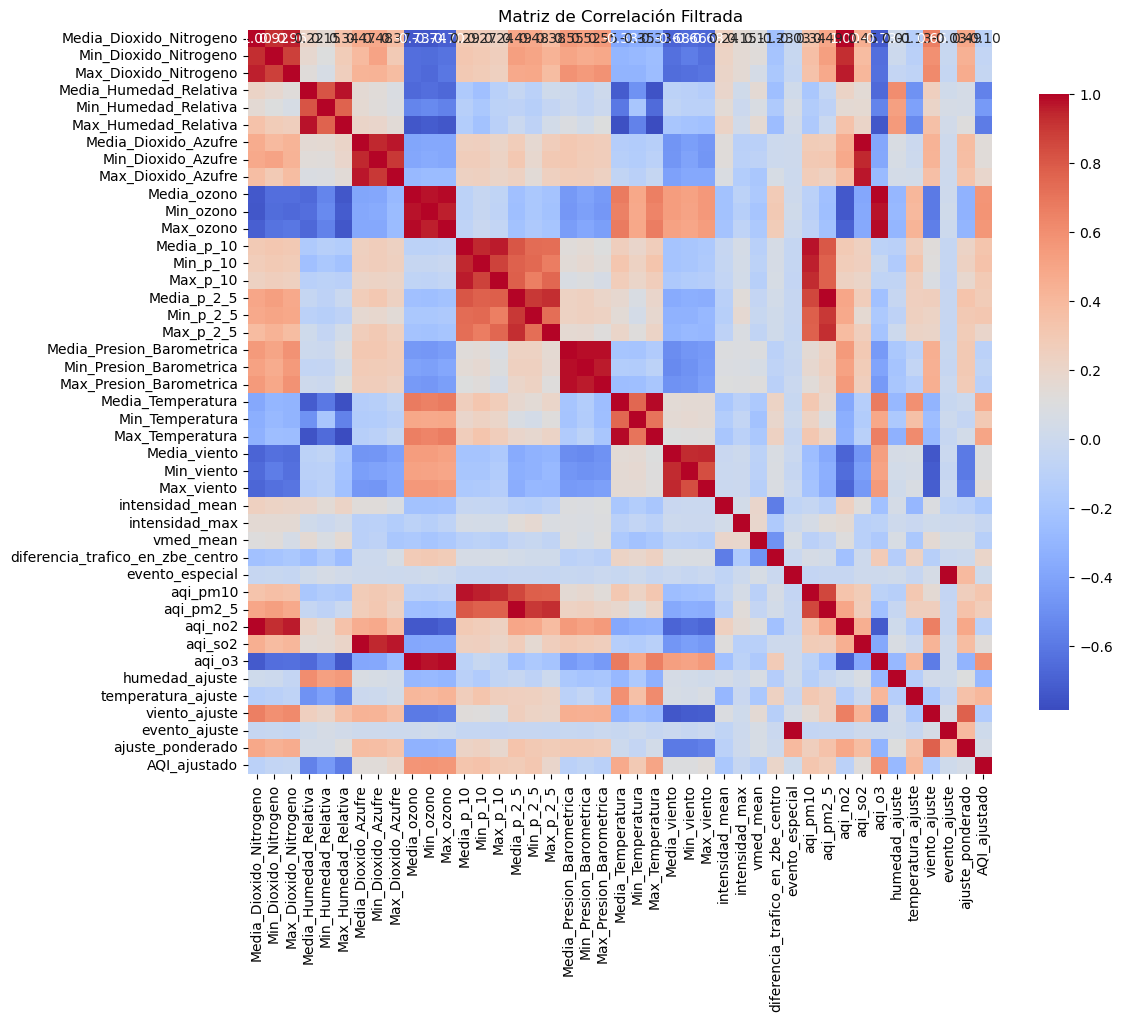

In [ ]:
# Crear un DataFrame solo con las columnas numéricas de df_aqi_base
df_aqi_numerico = df_aqi_base.select_dtypes(include=['float64', 'int64'])

# Filtrar columnas constantes (sin variabilidad)
df_filtered = df_aqi_numerico.loc[:, df_aqi_numerico.nunique() > 1]

# Recalcular la matriz de correlación
correlation_matrix = df_filtered.corr()

# Verificar si hay valores NaN en la matriz de correlación
if correlation_matrix.isnull().values.any():
    print("La matriz de correlación contiene valores NaN. Investigar más a fondo.")
else:
    print("La matriz de correlación está limpia.")

# Mostrar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación Filtrada')
plt.show()

In [ ]:
# Mostrar la matriz de correlación
correlation_matrix

,Media_Dioxido_Nitrogeno,Min_Dioxido_Nitrogeno,Max_Dioxido_Nitrogeno,Media_Humedad_Relativa,Min_Humedad_Relativa,Max_Humedad_Relativa,Media_Dioxido_Azufre,Min_Dioxido_Azufre,Max_Dioxido_Azufre,Media_ozono,...,aqi_pm2_5,aqi_no2,aqi_so2,aqi_o3,humedad_ajuste,temperatura_ajuste,viento_ajuste,evento_ajuste,ajuste_ponderado,AQI_ajustado
Media_Dioxido_Nitrogeno,1.000000,0.923787,0.957874,0.217549,0.151604,0.340990,0.465246,0.482328,0.368253,-0.734701,...,0.491358,0.999731,0.454586,-0.729189,0.014601,-0.126422,0.664851,-0.032640,0.487813,-0.101406
Min_Dioxido_Nitrogeno,0.923787,1.000000,0.880306,0.170771,0.103927,0.280520,0.390427,0.510982,0.292999,-0.645524,...,0.529114,0.924446,0.380576,-0.639906,-0.003186,-0.102907,0.593701,-0.026842,0.439449,-0.059286
Max_Dioxido_Nitrogeno,0.957874,0.880306,1.000000,0.125320,0.064625,0.253920,0.421326,0.430863,0.376598,-0.642205,...,0.483533,0.958395,0.411275,-0.636945,-0.046587,-0.077905,0.623022,-0.043685,0.465423,-0.046366
Media_Humedad_Relativa,0.217549,0.170771,0.125320,1.000000,0.817272,0.972104,0.150165,0.132112,0.083162,-0.664160,...,-0.042208,0.216217,0.148184,-0.666996,0.605270,-0.488388,0.249459,0.022862,0.046048,-0.561179
Min_Humedad_Relativa,0.151604,0.103927,0.064625,0.817272,1.000000,0.766313,0.159848,0.127942,0.091579,-0.547569,...,-0.085186,0.149397,0.158154,-0.549986,0.518806,-0.411826,0.207753,0.055399,0.050879,-0.448711
Max_Humedad_Relativa,0.340990,0.280520,0.253920,0.972104,0.766313,1.000000,0.211571,0.193725,0.137518,-0.738040,...,-0.018214,0.339166,0.208570,-0.741004,0.548380,-0.523741,0.357552,0.025986,0.111902,-0.587565
Media_Dioxido_Azufre,0.465246,0.390427,0.421326,0.150165,0.159848,0.211571,1.000000,0.940416,0.969786,-0.391632,...,0.270055,0.461795,0.999551,-0.387745,0.072350,-0.010107,0.431646,0.005715,0.374090,0.132934
Min_Dioxido_Azufre,0.482328,0.510982,0.430863,0.132112,0.127942,0.193725,0.940416,1.000000,0.897545,-0.385107,...,0.307803,0.478831,0.939359,-0.380736,0.059319,-0.001611,0.422614,0.008632,0.370135,0.134268
Max_Dioxido_Azufre,0.368253,0.292999,0.376598,0.083162,0.091579,0.137518,0.969786,0.897545,1.000000,-0.278622,...,0.238587,0.365225,0.971498,-0.275054,0.039185,0.037060,0.362130,0.001184,0.333840,0.185775
Media_ozono,-0.734701,-0.645524,-0.642205,-0.664160,-0.547569,-0.738040,-0.391632,-0.385107,-0.278622,1.000000,...,-0.240996,-0.732212,-0.383377,0.999778,-0.290689,0.408318,-0.591854,0.008734,-0.323189,0.573798


In [ ]:
df_filtered.columns

Index(['Media_Dioxido_Nitrogeno', 'Min_Dioxido_Nitrogeno',
       'Max_Dioxido_Nitrogeno', 'Media_Humedad_Relativa',
       'Min_Humedad_Relativa', 'Max_Humedad_Relativa', 'Media_Dioxido_Azufre',
       'Min_Dioxido_Azufre', 'Max_Dioxido_Azufre', 'Media_ozono', 'Min_ozono',
       'Max_ozono', 'Media_p_10', 'Min_p_10', 'Max_p_10', 'Media_p_2_5',
       'Min_p_2_5', 'Max_p_2_5', 'Media_Presion_Barometrica',
       'Min_Presion_Barometrica', 'Max_Presion_Barometrica',
       'Media_Temperatura', 'Min_Temperatura', 'Max_Temperatura',
       'Media_viento', 'Min_viento', 'Max_viento', 'intensidad_mean',
       'intensidad_max', 'vmed_mean', 'diferencia_trafico_en_zbe_centro',
       'evento_especial', 'aqi_pm10', 'aqi_pm2_5', 'aqi_no2', 'aqi_so2',
       'aqi_o3', 'humedad_ajuste', 'temperatura_ajuste', 'viento_ajuste',
       'evento_ajuste', 'ajuste_ponderado', 'AQI_ajustado'],
      dtype='object')

In [ ]:
# Calcular la matriz de correlación solo para columnas numéricas
correlation_matrix = df_filtered.corr()

# Ordenar las correlaciones con respecto a 'AQI_ajustado'
correlation_with_aqi_ajustado = correlation_matrix["AQI_ajustado"].sort_values(ascending=False)

# Mostrar las correlaciones ordenadas
print(correlation_with_aqi_ajustado)

AQI_ajustado                        1.000000
aqi_o3                              0.585603
Min_ozono                           0.578833
Media_ozono                         0.573798
Max_ozono                           0.564211
Max_Temperatura                     0.500590
Media_Temperatura                   0.476047
temperatura_ajuste                  0.400864
Min_p_10                            0.337252
Media_p_10                          0.327649
aqi_pm10                            0.321891
Min_p_2_5                           0.310304
Min_Temperatura                     0.299271
Max_p_10                            0.293604
Media_p_2_5                         0.277371
aqi_pm2_5                           0.274455
diferencia_trafico_en_zbe_centro    0.199558
Max_p_2_5                           0.192103
Max_Dioxido_Azufre                  0.185775
Min_Dioxido_Azufre                  0.134268
Max_viento                          0.133616
Media_Dioxido_Azufre                0.132934
aqi_so2   

In [ ]:
# Seleccionar las columnas que deseas conservar
selected_columns = [
    'Fecha', 'aqi_o3', 'Min_ozono', 'Media_ozono', 'Max_ozono',
    'Max_Temperatura', 'Media_Temperatura', 'temperatura_ajuste',
    'Min_p_10', 'Media_p_10', 'aqi_pm10', 'Min_p_2_5',
    'Min_Temperatura', 'Max_p_10', 'Media_p_2_5', 'aqi_pm2_5',
    'diferencia_trafico_en_zbe_centro', 'AQI_ajustado', 'Max_viento',
    'Max_Humedad_Relativa', 'Media_Humedad_Relativa', 'Min_Humedad_Relativa',
    'humedad_ajuste', 'intensidad_mean', 'viento_ajuste', 'vmed_mean', 'AQI_ajustado',
]

# Create the new DataFrame
df_aqi_personalizado = df_aqi_base[selected_columns].copy()

# Display the first few rows of the new DataFrame
print(df_aqi_personalizado.head())

        Fecha     aqi_o3  Min_ozono  Media_ozono  Max_ozono  Max_Temperatura  \
0  2021-01-01  50.923077         46    54.923077         65              6.3   
1  2021-01-02  43.803419         38    47.307692         57              5.3   
2  2021-01-03  28.988604         24    31.307692         38              5.1   
3  2021-01-04  37.820513         26    40.846154         55              4.7   
4  2021-01-05  16.595442         12    17.923077         24              5.5   

   Media_Temperatura  temperatura_ajuste  Min_p_10  Media_p_10  ...  \
0           3.972000                 1.0         3    4.769231  ...   
1           2.224000                 1.0         4    5.384615  ...   
2           2.308333                 1.0         5    8.230769  ...   
3           2.933333                 1.0         5    7.846154  ...   
4           1.212500                 1.0        12   16.846154  ...   

   AQI_ajustado  Max_viento  Max_Humedad_Relativa  Media_Humedad_Relativa  \
0        52.020

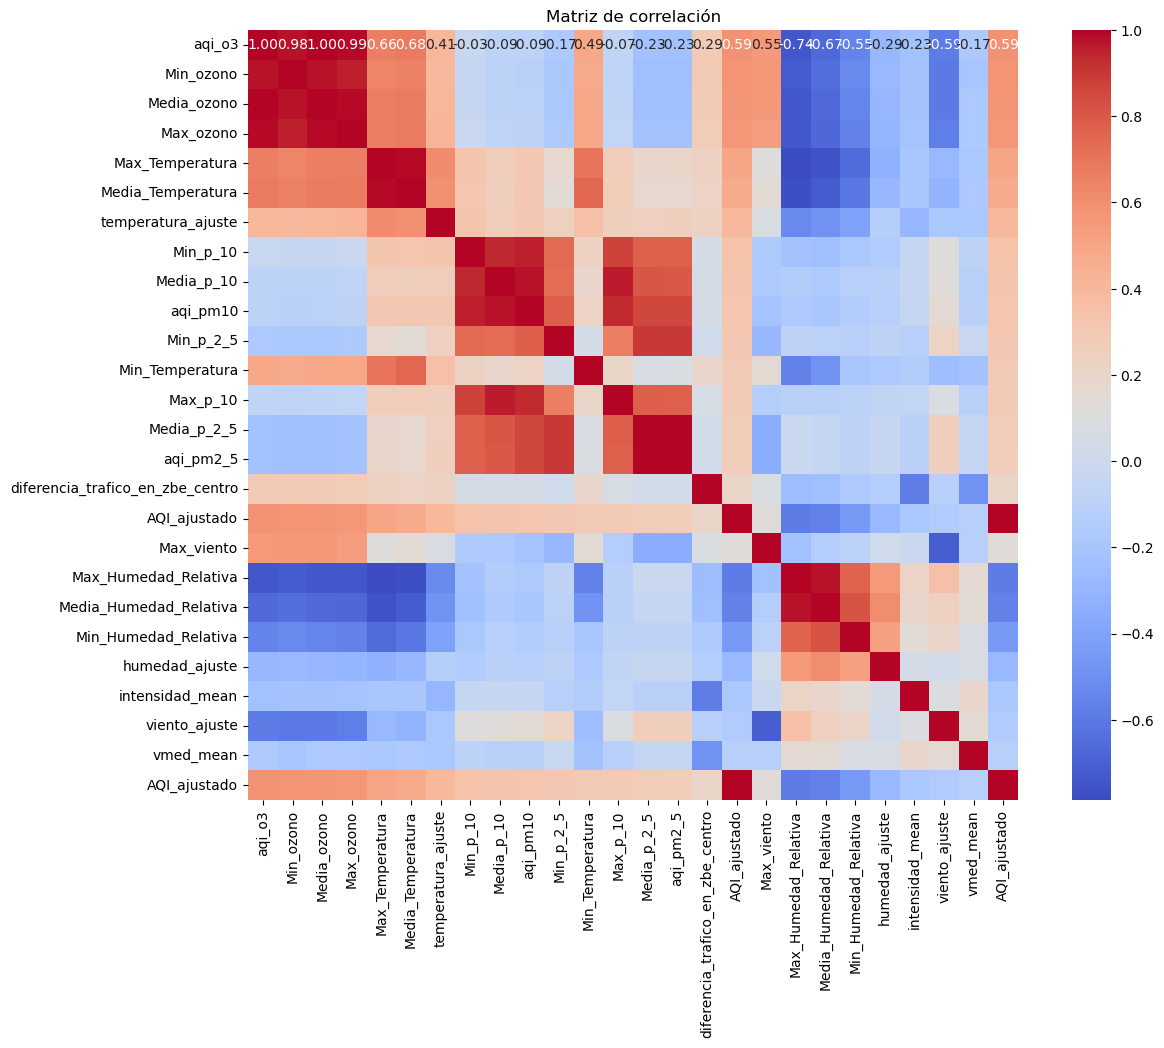

Variables altamente correlacionadas (>|0.9|):
aqi_o3 ↔ Min_ozono → correlación = 0.98
aqi_o3 ↔ Media_ozono → correlación = 1.00
aqi_o3 ↔ Max_ozono → correlación = 0.99
Min_ozono ↔ Media_ozono → correlación = 0.98
Min_ozono ↔ Max_ozono → correlación = 0.96
Media_ozono ↔ Max_ozono → correlación = 0.99
Max_Temperatura ↔ Media_Temperatura → correlación = 0.99
Min_p_10 ↔ Media_p_10 → correlación = 0.94
Min_p_10 ↔ aqi_pm10 → correlación = 0.95
Media_p_10 ↔ aqi_pm10 → correlación = 0.98
Media_p_10 ↔ Max_p_10 → correlación = 0.96
aqi_pm10 ↔ Max_p_10 → correlación = 0.94
Min_p_2_5 ↔ Media_p_2_5 → correlación = 0.90
Media_p_2_5 ↔ aqi_pm2_5 → correlación = 1.00
AQI_ajustado ↔ AQI_ajustado → correlación = 1.00
Max_Humedad_Relativa ↔ Media_Humedad_Relativa → correlación = 0.97


In [ ]:

df_numericas = df_aqi_personalizado.select_dtypes(include=['float64', 'int64'])

# El resto del código sigue igual...
correlacion = df_numericas.corr()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Matriz de correlación")
plt.show()

# Umbral para definir "alta correlación"
umbral = 0.9
correlaciones_altas = []

for i in range(correlacion.shape[0]):
    for j in range(i + 1, correlacion.shape[1]):
        if abs(correlacion.iloc[i, j]) > umbral:
            correlaciones_altas.append((
                correlacion.index[i],
                correlacion.columns[j],
                correlacion.iloc[i, j]
            ))

print("Variables altamente correlacionadas (>|0.9|):")
for var1, var2, corr in correlaciones_altas:
    print(f"{var1} ↔ {var2} → correlación = {corr:.2f}")


A causa de generación de overfiting vamos a eliminar las variables con la correlación mas elevada

In [ ]:
#eliminar columnas con alta correlación
df_aqi_personalizado = df_aqi_personalizado.drop(columns=['Max_ozono', 'Max_Temperatura', 'Max_p_10', 'Max_Humedad_Relativa', 'Min_ozono', 'Media_ozono', 'Min_p_2_5', 'Min_p_10', 'Media_p_2_5'])
# Mostrar las primeras filas del DataFrame para verificar que se cargó correctamente
print(df_aqi_personalizado.head())

        Fecha     aqi_o3  Media_Temperatura  temperatura_ajuste  Media_p_10  \
0  2021-01-01  50.923077           3.972000                 1.0    4.769231   
1  2021-01-02  43.803419           2.224000                 1.0    5.384615   
2  2021-01-03  28.988604           2.308333                 1.0    8.230769   
3  2021-01-04  37.820513           2.933333                 1.0    7.846154   
4  2021-01-05  16.595442           1.212500                 1.0   16.846154   

    aqi_pm10  Min_Temperatura  aqi_pm2_5  diferencia_trafico_en_zbe_centro  \
0   4.415954              1.3   4.821429                          -26.1060   
1   4.985755             -0.6   4.642857                          -11.9976   
2   7.621083             -1.7   8.035714                          -22.4208   
3   7.264957             -0.8   6.964286                          -29.7894   
4  15.598291             -3.5  16.071429                          -51.8846   

   AQI_ajustado  Max_viento  Media_Humedad_Relativa  Min

In [ ]:
df_aqi_personalizado.shape


(1549, 18)

Vamos a generar un nuevo daset (que se llamara tabla_AQI_personalizado) con las variables que vamos a usar para la predicción de nuestro aqi ajustado: 'Fecha', 'aqi_o3', 'Min_ozono', 'Media_ozono', 'Max_ozono','Max_Temperatura', 'Media_Temperatura', 'temperatura_ajuste','Min_p_10', 'Media_p_10', 'aqi_pm10', 'Min_p_2_5','Min_Temperatura', 'Max_p_10', 'Media_p_2_5', 'aqi_pm2_5','diferencia_trafico_en_zbe_centro', 'AQI_ajustado', 'Max_viento', 'Max_Humedad_Relativa', 'Media_Humedad_Relativa', 'Min_Humedad_Relativa','humedad_ajuste', 'intensidad_mean', 'viento_ajuste', 'vmed_mean' y 'AQI_ajustado'.

In [ ]:
# Guardar el DataFrame como un archivo CSV
df_aqi_personalizado.to_csv('f:\Descargas 1\Downloads\AQI_personalizado.csv', index=False)

<>:2: DeprecationWarning: invalid escape sequence '\D'
<>:2: DeprecationWarning: invalid escape sequence '\D'
C:\Users\leuqa\AppData\Local\Temp\ipykernel_2700\1527337199.py:2: DeprecationWarning: invalid escape sequence '\D'
  df_aqi_personalizado.to_csv('f:\Descargas 1\Downloads\AQI_personalizado.csv', index=False)


In [ ]:
df_aqi_personalizado.columns

Index(['Fecha', 'aqi_o3', 'Media_Temperatura', 'temperatura_ajuste',
       'Media_p_10', 'aqi_pm10', 'Min_Temperatura', 'aqi_pm2_5',
       'diferencia_trafico_en_zbe_centro', 'AQI_ajustado', 'Max_viento',
       'Media_Humedad_Relativa', 'Min_Humedad_Relativa', 'humedad_ajuste',
       'intensidad_mean', 'viento_ajuste', 'vmed_mean', 'AQI_ajustado'],
      dtype='object')

## **Comparamos diversos Modelos**

Vamos a realizar algunas comparaciones con diversos Modelos


In [ ]:
# Variable objetivo
y = df_aqi_personalizado['AQI_ajustado']
# Variables predictoras (excluyendo 'Fecha' y 'AQI_ajustado')
X = df_aqi_personalizado.drop(columns=['Fecha', 'AQI_ajustado'])


In [ ]:
# División de los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# Eliminar columnas duplicadas si existen
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Asegurar que y_train e y_test sean vectores unidimensionales
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0]

# Filtrar solo columnas numéricas
X_train = X_train.select_dtypes(include=['float64', 'int64'])
X_test = X_test.select_dtypes(include=['float64', 'int64'])

# ========================
# 4. Definición de modelos
# ========================
models = {
    'LinearRegression': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'KNeighbors': KNeighborsRegressor(),
    'SVR': SVR(),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# ========================
# 5. Entrenamiento y evaluación
# ========================
results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = r2_score(y_test, y_pred)
    results[name] = score
    predictions[name] = y_pred
    print(f"{name} R² Score: {score:.4f}")

LinearRegression R² Score: 0.6045
RandomForest R² Score: 0.8886
DecisionTree R² Score: 0.7156
KNeighbors R² Score: 0.7192
SVR R² Score: 0.3541
GradientBoosting R² Score: 0.8967
XGBoost R² Score: 0.8896


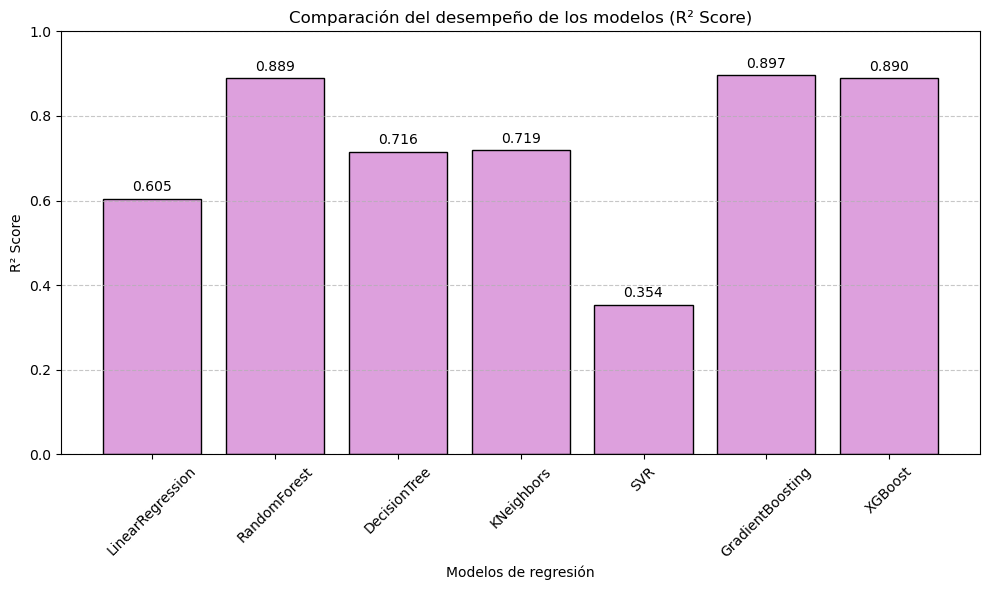

In [ ]:
import matplotlib.pyplot as plt

# Convertir resultados en listas para graficar
model_names = list(results.keys())
r2_scores = list(results.values())

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, r2_scores, color='plum', edgecolor='black')
plt.ylim(0, 1)
plt.title("Comparación del desempeño de los modelos (R² Score)")
plt.xlabel("Modelos de regresión")
plt.ylabel("R² Score")

# Añadir etiquetas encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- **Gráfico de barras de R² por modelo:**  
    Este gráfico muestra el coeficiente de determinación (R²) de cada modelo de regresión probado. Permite comparar de forma visual cuál de los algoritmos (Random Forest, XGBoost, Gradient Boosting, etc.) explica mejor la variabilidad del AQI ajustado. Un R² más alto indica mejor capacidad predictiva.

Revisaremos si realmente GradienBoosting es el mejor modelo o de lo contrario una vez hayamos ajustado los parametros nos sale otro modelo




## **Entrenamos el Modelo**

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1084, 15)
(465, 15)
(1084,)
(465,)


In [ ]:
# Realizar MinMaxScaler a los datos de entrenamiento
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Crear el pipe y el diccionario de algoritmos, parámetros y valores a testar

Modificar para dejar solo los algoritmos que se quieran testar.

Modificar los parámetros

In [ ]:
pipe = Pipeline([('algoritmo', RandomForestRegressor())])

grid = [
    {'algoritmo': [LinearRegression()]},

    {'algoritmo': [RandomForestRegressor()],
     'algoritmo__max_depth': [5, 10, 15],
     'algoritmo__n_estimators': [50, 100, 200]},

    {'algoritmo': [XGBRegressor()],
     'algoritmo__learning_rate': [0.01, 0.025, 0.05, 0.1],
     'algoritmo__max_depth': [5, 10, 20],
     'algoritmo__reg_alpha': [0, 0.1, 0.5, 1],
     'algoritmo__reg_lambda': [0.01, 0.1, 1],
     'algoritmo__n_estimators': [100, 500, 1000]},

    {'algoritmo': [KNeighborsRegressor()],
     'algoritmo__n_neighbors': [5, 10, 15, 20]},

    {'algoritmo': [GradientBoostingRegressor()],
     'algoritmo__learning_rate': [0.01, 0.05, 0.1],
     'algoritmo__n_estimators': [100, 300, 500],
     'algoritmo__max_depth': [3, 5, 7]}
]

In [ ]:
print(pipe)

Pipeline(steps=[('algoritmo', RandomForestRegressor())])


In [ ]:
from sklearn.model_selection import GridSearchCV

# Calcular con GridSearch
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=0
)

# Ajustar el modelo
modelo = grid_search.fit(X_train_scaled, y_train)

# Ver los mejores resultados
pd.DataFrame(modelo.cv_results_).sort_values('rank_test_score').head(20)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algoritmo,param_algoritmo__max_depth,param_algoritmo__n_estimators,param_algoritmo__learning_rate,param_algoritmo__reg_alpha,param_algoritmo__reg_lambda,param_algoritmo__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
242,4.026603,0.451516,0.020598,0.014597,"XGBRegressor(base_score=None, booster=None, ca...",5,500,0.05,0.1,0.1,NaN,"{'algoritmo': XGBRegressor(base_score=None, bo...",-2.689381,-2.295644,-2.305204,-2.730125,-2.580519,-2.520175,0.185999,1
254,9.594804,1.157658,0.022795,0.005846,"XGBRegressor(base_score=None, booster=None, ca...",5,1000,0.05,0.1,0.1,NaN,"{'algoritmo': XGBRegressor(base_score=None, bo...",-2.687486,-2.292873,-2.304102,-2.739671,-2.582763,-2.521379,0.188910,2
368,3.758596,0.262166,0.014403,0.005468,"XGBRegressor(base_score=None, booster=None, ca...",5,1000,0.1,1,0.1,NaN,"{'algoritmo': XGBRegressor(base_score=None, bo...",-2.640819,-2.354511,-2.311029,-2.789359,-2.602838,-2.539711,0.180625,3
356,3.252402,0.217954,0.012005,0.002760,"XGBRegressor(base_score=None, booster=None, ca...",5,500,0.1,1,0.1,NaN,"{'algoritmo': XGBRegressor(base_score=None, bo...",-2.640819,-2.354511,-2.311029,-2.789359,-2.602838,-2.539711,0.180625,3
261,6.675602,0.556646,0.022197,0.006208,"XGBRegressor(base_score=None, booster=None, ca...",5,1000,0.05,1,1,NaN,"{'algoritmo': XGBRegressor(base_score=None, bo...",-2.575118,-2.376634,-2.400101,-2.785830,-2.581906,-2.543918,0.148057,5
355,3.579200,0.504594,0.010800,0.001470,"XGBRegressor(base_score=None, booster=None, ca...",5,500,0.1,1,0.01,NaN,"{'algoritmo': XGBRegressor(base_score=None, bo...",-2.714118,-2.329212,-2.353788,-2.834163,-2.496528,-2.545562,0.198842,6
367,3.619800,0.092868,0.011601,0.003262,"XGBRegressor(base_score=None, booster=None, ca...",5,1000,0.1,1,0.01,NaN,"{'algoritmo': XGBRegressor(base_score=None, bo...",-2.714118,-2.329212,-2.353788,-2.834163,-2.496528,-2.545562,0.198842,6
343,1.009592,0.040900,0.006805,0.000754,"XGBRegressor(base_score=None, booster=None, ca...",5,100,0.1,1,0.01,NaN,"{'algoritmo': XGBRegressor(base_score=None, bo...",-2.759161,-2.350100,-2.339222,-2.801173,-2.512564,-2.552444,0.196263,8
249,3.819201,0.534406,0.012808,0.002146,"XGBRegressor(base_score=None, booster=None, ca...",5,500,0.05,1,1,NaN,"{'algoritmo': XGBRegressor(base_score=None, bo...",-2.593845,-2.383398,-2.411797,-2.786026,-2.596483,-2.554310,0.145983,9
260,6.035999,0.432282,0.017602,0.002333,"XGBRegressor(base_score=None, booster=None, ca...",5,1000,0.05,1,0.1,NaN,"{'algoritmo': XGBRegressor(base_score=None, bo...",-2.743102,-2.382916,-2.396630,-2.781806,-2.469640,-2.554819,0.172513,10


In [ ]:
modelo.best_estimator_

Pipeline(steps=[('algoritmo',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
# Predecir con el mejor estimador encontrado
y_pred = modelo.best_estimator_.predict(X_test)

# Métricas de evaluación
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("Nuevo R2:", r2_score(y_test, y_pred))
print("Nuevo MAE:", mean_absolute_error(y_test, y_pred))
print("Nuevo RMSE:", mean_squared_error(y_test, y_pred, squared=False))


Nuevo R2: 0.895836115451815
Nuevo MAE: 2.8265593063190413
Nuevo RMSE: 5.07121668567811


In [ ]:
# Visualizar las predicciones de X_test
y_pred

array([ 51.968636,  55.162354,  70.4422  ,  53.025146,  93.0183  ,
        65.389244,  47.409843,  39.838852,  61.28779 ,  52.114216,
        53.909103,  45.511517,  51.637486,  47.010292,  57.43974 ,
        57.855083,  59.85662 ,  45.885307,  46.98769 ,  43.57015 ,
        66.331184,  53.365673,  57.922894,  80.06946 ,  90.79979 ,
        66.5377  ,  48.311264,  54.562027,  53.244045, 100.11789 ,
        60.575127,  59.085457,  77.024826,  74.379845,  45.921112,
        62.745766,  70.96514 ,  69.47407 ,  89.49047 ,  88.97833 ,
        73.1278  ,  75.52882 ,  57.21484 ,  62.551373,  51.508686,
        73.24858 ,  56.548004,  51.02319 ,  57.697998,  47.143143,
        76.83564 ,  52.043503,  58.969162,  85.986404,  85.67117 ,
        42.434498,  65.80959 ,  61.580296,  61.90678 ,  58.099094,
        81.2776  ,  68.11567 ,  48.873882,  46.922646,  64.10658 ,
        35.711678,  53.343464,  50.44774 ,  88.48641 ,  80.76442 ,
        57.823017,  40.501694,  76.51199 ,  70.179436,  50.106

In [ ]:
y_pred.shape

(465,)

In [ ]:
# Predecir con el mejor estimador en los datos de entrenamiento
y_train_pred = modelo.best_estimator_.predict(X_train)

# Métricas de evaluación para entrenamiento
print("Train R2:", r2_score(y_train, y_train_pred))
print("Train MAE:", mean_absolute_error(y_train, y_train_pred))
print("Train RMSE:", mean_squared_error(y_train, y_train_pred, squared=False))


Train R2: 0.9993818739252033
Train MAE: 0.2651973283070921
Train RMSE: 0.39006816750101125


In [ ]:
y_train_pred

array([44.50733 , 52.71051 , 43.785954, ..., 70.32265 , 52.68531 ,
       58.884727], dtype=float32)

In [ ]:
y_train_pred.shape

(1084,)

In [ ]:
# Convertimos a Series para mantener el índice
y_train_pred_series = pd.Series(y_train_pred, index=y_train.index, name='Predicho')
y_test_pred_series = pd.Series(y_pred, index=y_test.index, name='Predicho')


In [ ]:
y_pred_total = pd.concat([y_train_pred_series, y_test_pred_series]).sort_index()
y_pred_total

0       51.930199
1       44.824120
2       31.664515
3       38.814148
4       53.499901
          ...    
1544    58.481339
1545    54.901516
1546    59.363266
1547    65.651741
1548    50.007023
Name: Predicho, Length: 1549, dtype: float32

In [ ]:
# Cargar el archivo CSV 'AQI_personalizado.csv' desde la ruta especificada
df_aqi_personalizado_csv = pd.read_csv(r'f:\Descargas 1\Downloads\AQI_personalizado.csv')

# Mostrar las primeras filas para verificar la carga
print(df_aqi_personalizado_csv.head())

        Fecha     aqi_o3  Min_ozono  Media_ozono  Max_ozono  Max_Temperatura  \
0  2021-01-01  50.923077         46    54.923077         65              6.3   
1  2021-01-02  43.803419         38    47.307692         57              5.3   
2  2021-01-03  28.988604         24    31.307692         38              5.1   
3  2021-01-04  37.820513         26    40.846154         55              4.7   
4  2021-01-05  16.595442         12    17.923077         24              5.5   

   Media_Temperatura  temperatura_ajuste  Min_p_10  Media_p_10  ...  \
0           3.972000                 1.0         3    4.769231  ...   
1           2.224000                 1.0         4    5.384615  ...   
2           2.308333                 1.0         5    8.230769  ...   
3           2.933333                 1.0         5    7.846154  ...   
4           1.212500                 1.0        12   16.846154  ...   

   AQI_ajustado  Max_viento  Max_Humedad_Relativa  Media_Humedad_Relativa  \
0        52.020

In [ ]:
# Añadir la columna 'Predicho' al DataFrame df_aqi_personalizado
# Aseguramos que el índice coincida para la asignación correcta
df_aqi_predicciones = df_aqi_personalizado.copy()
df_aqi_predicciones['Predicho'] = y_pred_total.values

# Mostrar las primeras filas para verificar
print(df_aqi_predicciones.head())

        Fecha     aqi_o3  Media_Temperatura  temperatura_ajuste  Media_p_10  \
0  2021-01-01  50.923077           3.972000                 1.0    4.769231   
1  2021-01-02  43.803419           2.224000                 1.0    5.384615   
2  2021-01-03  28.988604           2.308333                 1.0    8.230769   
3  2021-01-04  37.820513           2.933333                 1.0    7.846154   
4  2021-01-05  16.595442           1.212500                 1.0   16.846154   

    aqi_pm10  Min_Temperatura  aqi_pm2_5  diferencia_trafico_en_zbe_centro  \
0   4.415954              1.3   4.821429                          -26.1060   
1   4.985755             -0.6   4.642857                          -11.9976   
2   7.621083             -1.7   8.035714                          -22.4208   
3   7.264957             -0.8   6.964286                          -29.7894   
4  15.598291             -3.5  16.071429                          -51.8846   

   AQI_ajustado  Max_viento  Media_Humedad_Relativa  Min

In [ ]:
print(df_aqi_predicciones[['Fecha', 'AQI_ajustado', 'Predicho']].head())

        Fecha  AQI_ajustado  AQI_ajustado   Predicho
0  2021-01-01        52.020        52.020  51.930199
1  2021-01-02        44.880        44.880  44.824120
2  2021-01-03        31.620        31.620  31.664515
3  2021-01-04        38.760        38.760  38.814148
4  2021-01-05        53.295        53.295  53.499901


In [ ]:
# Verificar columnas duplicadas en df_aqi_predicciones
duplicated_cols = df_aqi_predicciones.columns[df_aqi_predicciones.columns.duplicated()].tolist()
print("Columnas duplicadas:", duplicated_cols)

# Eliminar columnas duplicadas (mantener solo la primera aparición)
df_aqi_predicciones = df_aqi_predicciones.loc[:, ~df_aqi_predicciones.columns.duplicated()]

# Verificar resultado
print("Columnas después de eliminar duplicadas:", df_aqi_predicciones.columns.tolist())

Columnas duplicadas: ['AQI_ajustado']
Columnas después de eliminar duplicadas: ['Fecha', 'aqi_o3', 'Media_Temperatura', 'temperatura_ajuste', 'Media_p_10', 'aqi_pm10', 'Min_Temperatura', 'aqi_pm2_5', 'diferencia_trafico_en_zbe_centro', 'AQI_ajustado', 'Max_viento', 'Media_Humedad_Relativa', 'Min_Humedad_Relativa', 'humedad_ajuste', 'intensidad_mean', 'viento_ajuste', 'vmed_mean', 'Predicho']


In [ ]:
# Función para clasificar el AQI
def clasificar_aqi(aqi):
    if pd.isna(aqi):
        return "Sin datos", "⬜️"
    elif aqi <= 50:
        return "Buena", "🔵"
    elif aqi <= 100:
        return "Razonablemente buena", "🟢"
    elif aqi <= 150:
        return "Regular", "🟡"
    elif aqi <= 200:
        return "Desfavorable", "🔴"
    elif aqi <= 300:
        return "Muy desfavorable", "🟤"
    else:
        return "Extremadamente desfavorable", "🟣"

# Aplicar clasificación al AQI estimado (valor real)
df_aqi_predicciones[['Clasificacion_AQI_Estimado', 'Color_AQI_Estimado']] = (
    df_aqi_predicciones['AQI_ajustado']
    .apply(clasificar_aqi)
    .apply(pd.Series)
)

# Aplicar clasificación al AQI personalizado (predicción del modelo)
df_aqi_predicciones[['Clasificacion_AQI_Personalizado', 'Color_AQI_Personalizado']] = (
    df_aqi_predicciones['Predicho']
    .apply(clasificar_aqi)
    .apply(pd.Series)
)

# Visualizar solo las columnas solicitadas
display(df_aqi_predicciones[['Fecha', 'AQI_ajustado', 'Predicho',
                            'Clasificacion_AQI_Estimado', 'Color_AQI_Estimado',
                            'Clasificacion_AQI_Personalizado', 'Color_AQI_Personalizado']])


,Fecha,AQI_ajustado,Predicho,Clasificacion_AQI_Estimado,Color_AQI_Estimado,Clasificacion_AQI_Personalizado,Color_AQI_Personalizado
0,2021-01-01,52.020,51.930199,Razonablemente buena,🟢,Razonablemente buena,🟢
1,2021-01-02,44.880,44.824120,Buena,🔵,Buena,🔵
2,2021-01-03,31.620,31.664515,Buena,🔵,Buena,🔵
3,2021-01-04,38.760,38.814148,Buena,🔵,Buena,🔵
4,2021-01-05,53.295,53.499901,Razonablemente buena,🟢,Razonablemente buena,🟢
...,...,...,...,...,...,...,...
1544,2025-03-27,58.710,58.481339,Razonablemente buena,🟢,Razonablemente buena,🟢
1545,2025-03-28,54.590,54.901516,Razonablemente buena,🟢,Razonablemente buena,🟢
1546,2025-03-29,59.160,59.363266,Razonablemente buena,🟢,Razonablemente buena,🟢
1547,2025-03-30,65.280,65.651741,Razonablemente buena,🟢,Razonablemente buena,🟢


## **📊 Resultados del Ajuste del AQI y del Modelo**



### **Ajuste del AQI**
El ajuste del AQI se realizó utilizando un enfoque personalizado que incorpora variables adicionales como condiciones meteorológicas y de tráfico. Este ajuste permite reflejar de manera más precisa las condiciones locales que afectan la calidad del aire. Al incluir factores como la humedad, la velocidad del viento, la intensidad del tráfico y eventos especiales, el modelo ajusta el AQI base para capturar mejor las dinámicas reales de contaminación en el entorno urbano.

El resultado es un índice más representativo que no solo considera las concentraciones de contaminantes, sino también las condiciones que influyen en su dispersión y acumulación. Esto proporciona una herramienta más útil para la toma de decisiones en la gestión de la calidad del aire.



### **Resultados del Modelo**
El modelo desarrollado para predecir el AQI ajustado muestra un desempeño sólido, como lo indican las métricas de evaluación:

- **MAE (Mean Absolute Error): 2.826**  
    En promedio, las predicciones del modelo se desvían solo 2.82 unidades del valor real del AQI ajustado. Este error absoluto medio bajo indica que el modelo tiene una alta precisión en la mayoría de los casos.

- **RMSE (Root Mean Squared Error): 5.071**  
    La raíz cuadrada del error cuadrático medio, que penaliza más los errores grandes, es de 5.07. Este valor refuerza la idea de que el modelo tiene un buen desempeño general, con errores relativamente pequeños.

- **R-squared (R²): 0.895**  
    El modelo explica el 89.5% de la variabilidad en los datos del AQI ajustado. Este valor cercano a 1 indica que el modelo tiene un ajuste fuerte y captura la mayoría de las relaciones entre las variables predictoras y el AQI ajustado.

---

### **Conclusión**
El ajuste del AQI y el modelo predictivo desarrollado ofrecen una herramienta robusta para evaluar y anticipar la calidad del aire. El enfoque personalizado permite incorporar factores locales que afectan la contaminación, mientras que el modelo predictivo demuestra un alto nivel de precisión y capacidad explicativa. Esto lo convierte en una solución valiosa para la gestión ambiental y la toma de decisiones informadas en contextos urbanos.
```

--------------------------------------------------------------

In [ ]:
#guardar el modelo
import joblib
joblib.dump(modelo, 'f:\Descargas 1\Downloads\modelo_ajustado.pkl')

['f:\\Descargas 1\\Downloads\\modelo_ajustado.pkl']

In [ ]:
# Guardar el DataFrame como archivo CSV
df_aqi_predicciones.to_csv('aqi_personalizado_general.csv', index=False)

print("Archivo guardado como 'aqi_personalizado_general.csv' en el directorio del proyecto.")

Archivo guardado como 'aqi_personalizado_general.csv' en el directorio del proyecto.


### **Graficas comparativas**

In [ ]:
new_df = df_aqi_predicciones.copy()


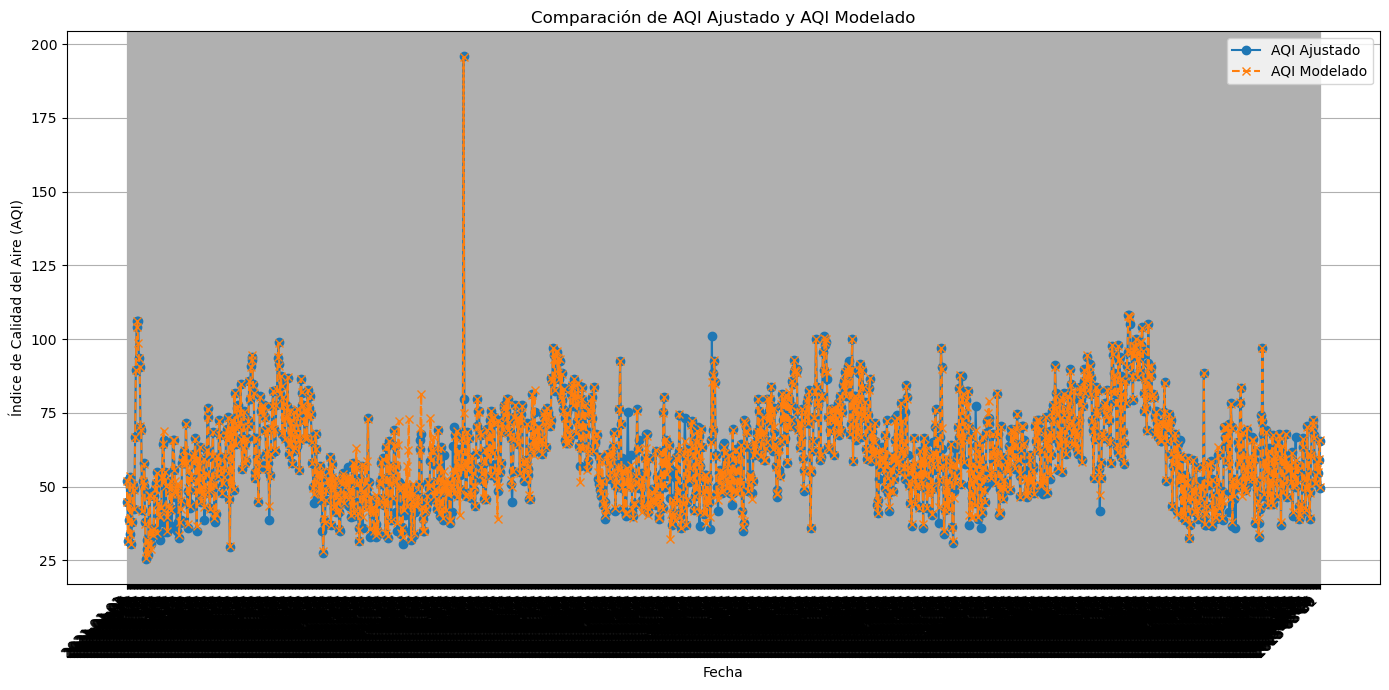

In [ ]:
# Crear la gráfica lineal
plt.figure(figsize=(14, 7))  # Ajustar el tamaño de la figura
plt.plot(df['Fecha'], new_df['AQI_ajustado'], label='AQI Ajustado', marker='o', linestyle='-')
plt.plot(df['Fecha'], new_df['Predicho'], label='AQI Modelado', marker='x', linestyle='--')

# Personalizar la gráfica
plt.xlabel('Fecha')
plt.ylabel('Índice de Calidad del Aire (AQI)')
plt.title('Comparación de AQI Ajustado y AQI Modelado')
plt.legend()
plt.grid(True)  # Agregar una cuadrícula
plt.xticks(rotation=45, ha='right') # Rotar las etiquetas del eje x para mejor legibilidad
plt.tight_layout() # Ajustar el diseño para evitar que las etiquetas se superpongan

# Mostrar la gráfica
plt.show()


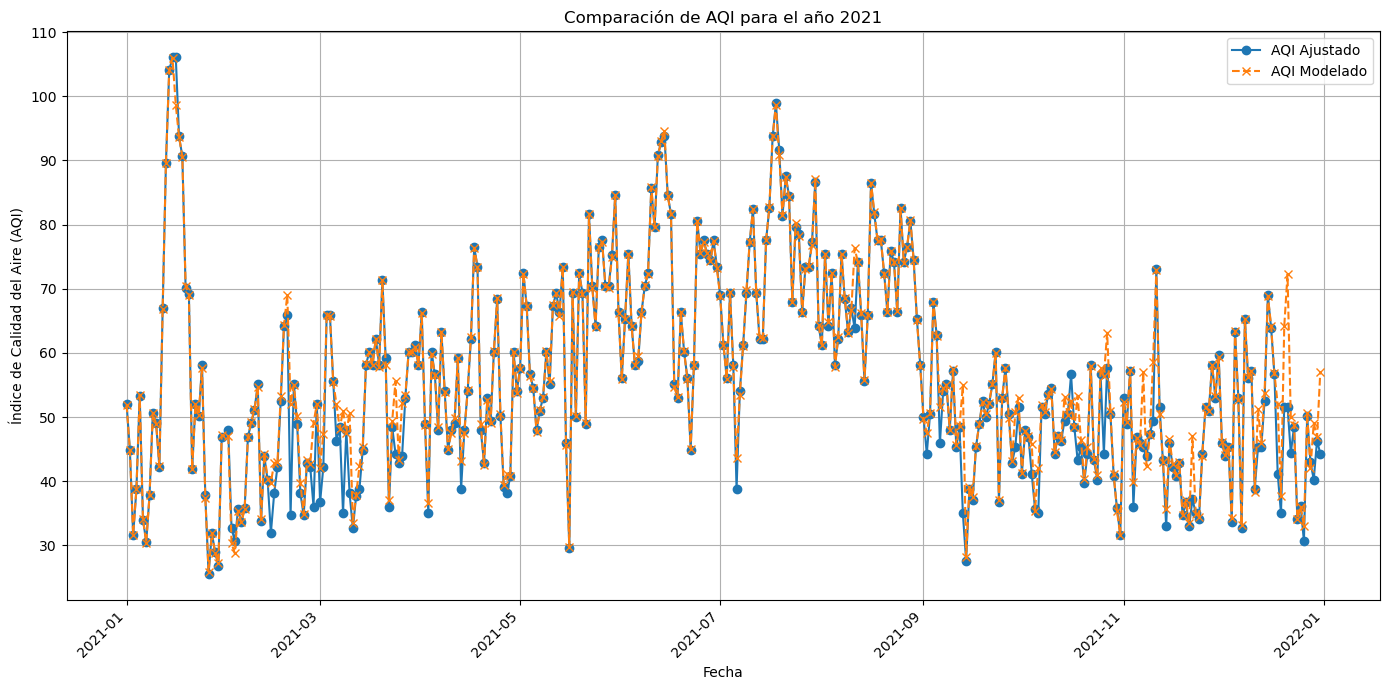

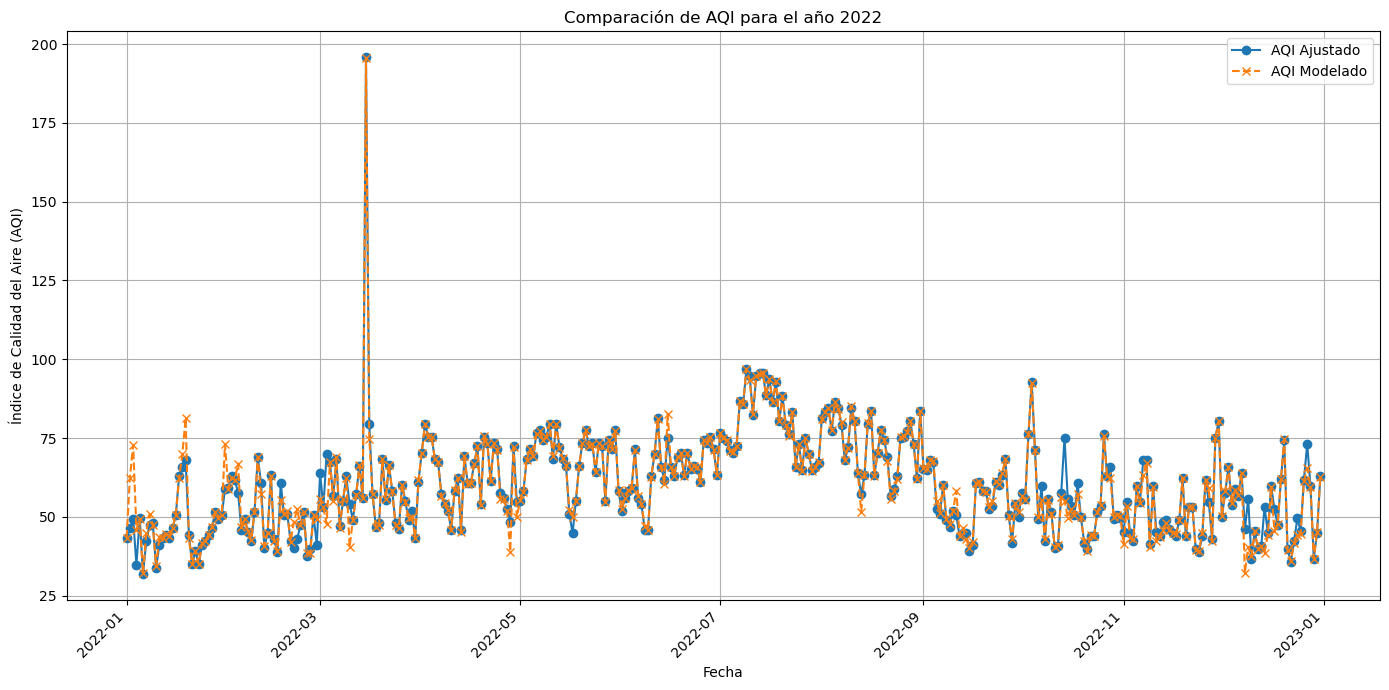

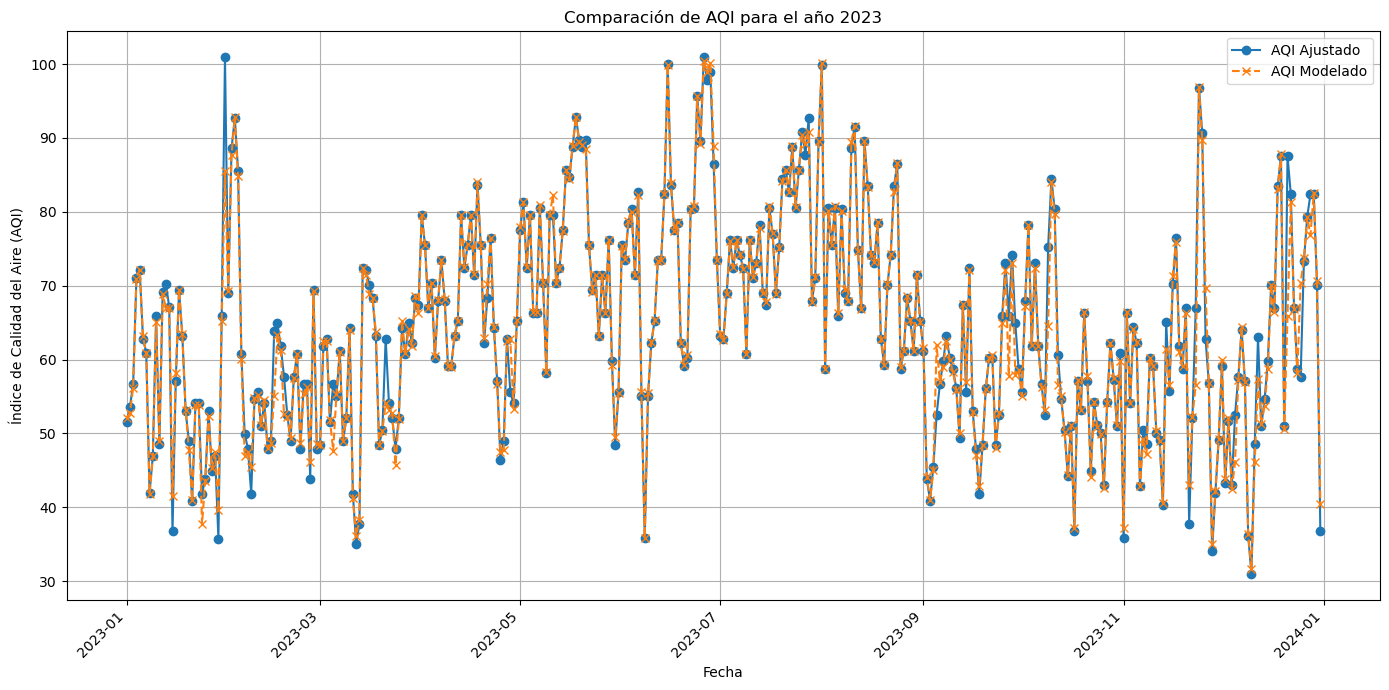

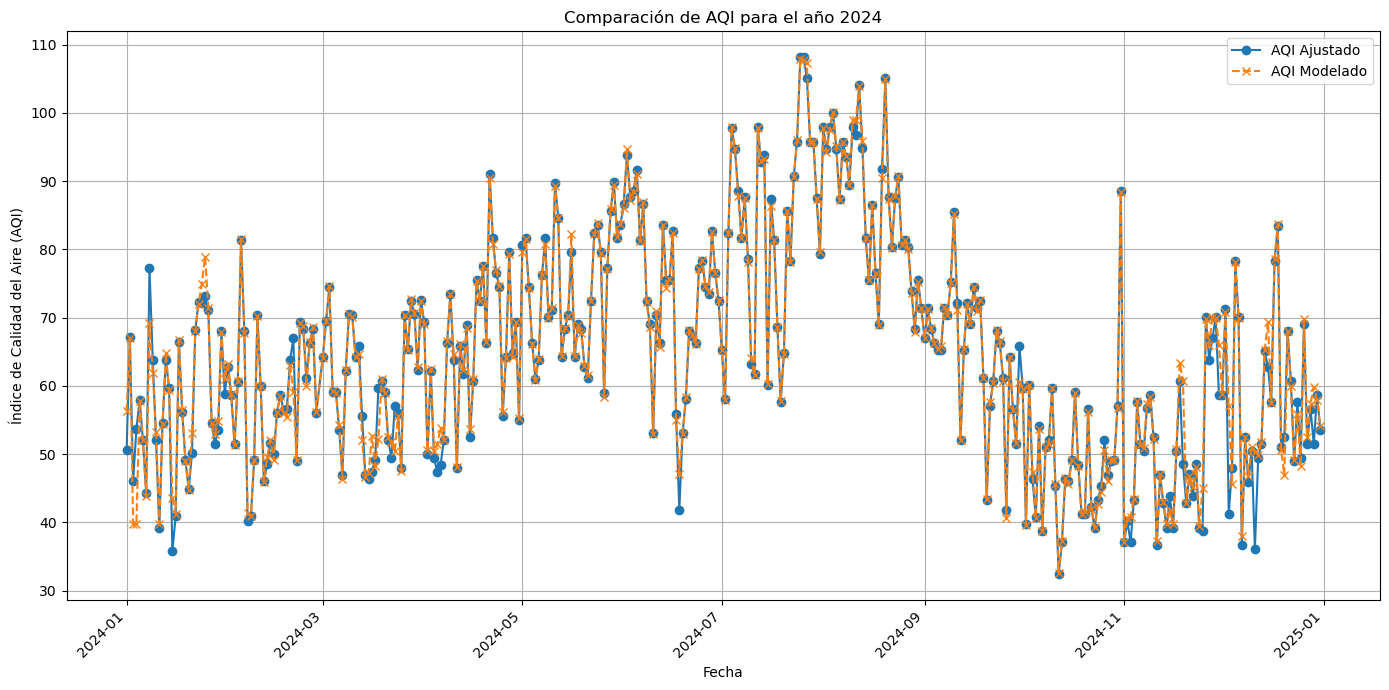

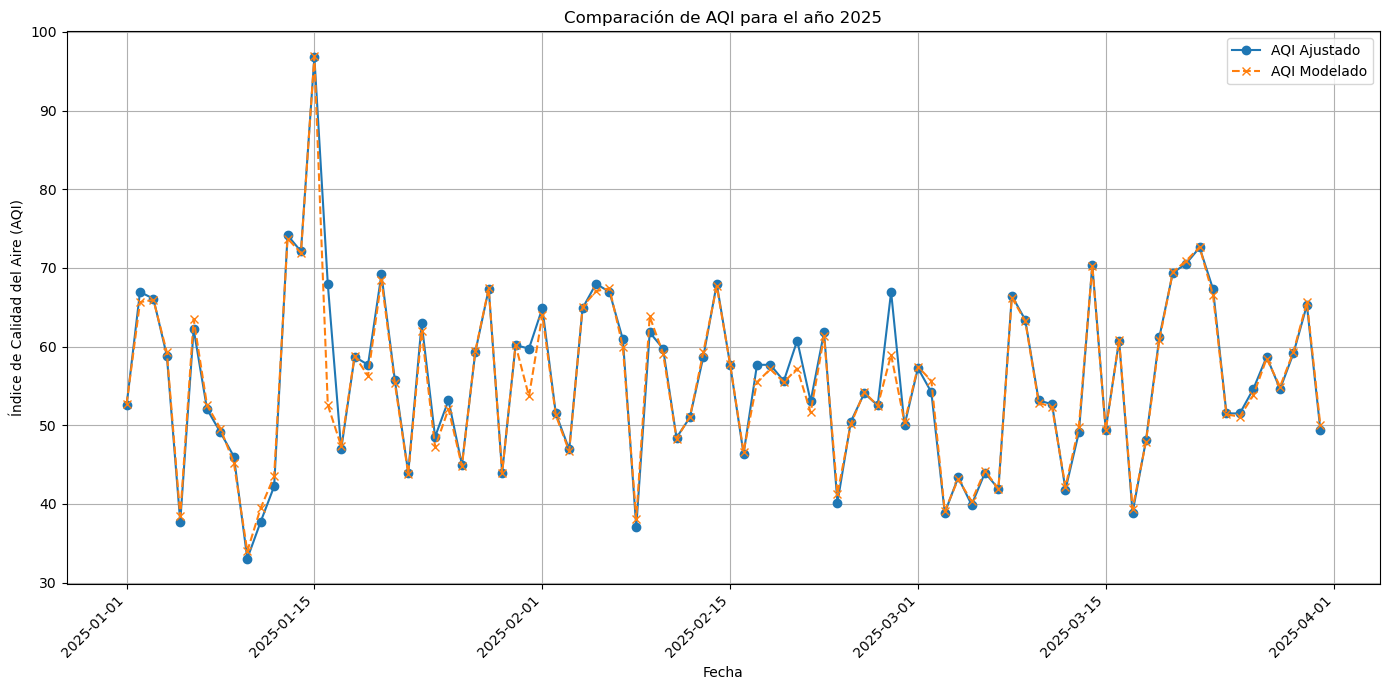

In [ ]:


# Grupos de datos por años
new_df['Fecha'] = pd.to_datetime(df['Fecha'])
new_df['Year'] = new_df['Fecha'].dt.year

for year in new_df['Year'].unique():
    year_data = new_df[new_df['Year'] == year]

    plt.figure(figsize=(14, 7))
    plt.plot(year_data['Fecha'], year_data['AQI_ajustado'], label='AQI Ajustado', marker='o', linestyle='-')
    plt.plot(year_data['Fecha'], year_data['Predicho'], label='AQI Modelado', marker='x', linestyle='--')

    plt.xlabel('Fecha')
    plt.ylabel('Índice de Calidad del Aire (AQI)')
    plt.title(f'Comparación de AQI para el año {year}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


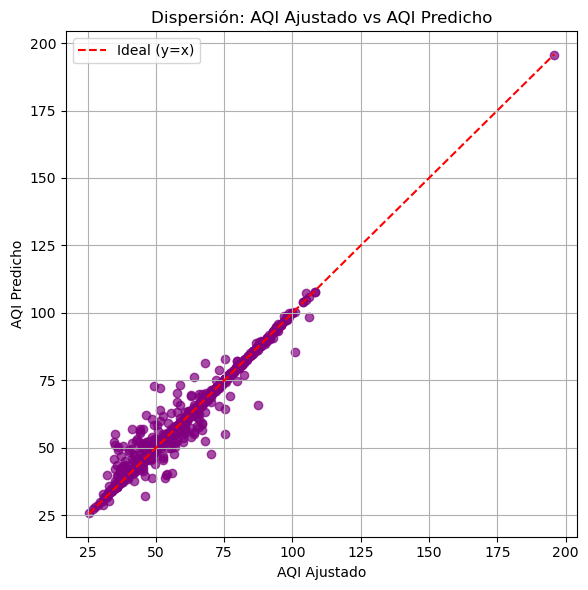

In [ ]:
# Gráfico de dispersión para ver la relación entre ambos
plt.figure(figsize=(6, 6))
plt.scatter(df_aqi_predicciones['AQI_ajustado'], df_aqi_predicciones['Predicho'], color='purple', alpha=0.7)
plt.plot([df_aqi_predicciones['AQI_ajustado'].min(), df_aqi_predicciones['AQI_ajustado'].max()],
         [df_aqi_predicciones['AQI_ajustado'].min(), df_aqi_predicciones['AQI_ajustado'].max()],
         'r--', label='Ideal (y=x)')
plt.xlabel('AQI Ajustado')
plt.ylabel('AQI Predicho')
plt.title('Dispersión: AQI Ajustado vs AQI Predicho')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Resumen de los Gráficos Comparativos

A lo largo del proyecto se han generado varios gráficos comparativos para analizar el desempeño del modelo y la utilidad del AQI personalizado:



- **Gráfica lineal AQI ajustado vs. AQI modelado:**  
    Se representa la evolución temporal del AQI ajustado (real) y el AQI predicho por el modelo para todo el periodo disponible. Permite observar la capacidad del modelo para seguir las tendencias y picos de contaminación, así como identificar posibles desviaciones entre la predicción y la realidad.

- **Gráficas lineales por año:**  
    Se generan gráficos individuales para cada año, comparando el AQI ajustado y el AQI modelado día a día. Esto facilita el análisis de la precisión del modelo en distintos contextos anuales y estacionales, y ayuda a detectar si el modelo mantiene su desempeño de forma consistente a lo largo del tiempo.

- **Gráfico de dispersión AQI ajustado vs. AQI predicho:**  
    Este scatter plot compara directamente los valores reales y predichos de AQI. La línea diagonal representa la predicción perfecta (y = x). Cuanto más cerca estén los puntos de esta línea, mejor es la precisión del modelo. Permite identificar sesgos sistemáticos o errores puntuales.

Estos gráficos, en conjunto, permiten validar visualmente la robustez del modelo, su capacidad de generalización y la utilidad del AQI personalizado para reflejar la realidad ambiental de manera más precisa.

## **6. 📊 Conclusión Final**

El desarrollo de este proyecto ha permitido crear un modelo avanzado para la predicción y ajuste del Índice de Calidad del Aire (AQI), integrando no solo los contaminantes tradicionales, sino también variables meteorológicas y de tráfico relevantes para el contexto urbano. El enfoque personalizado, basado en multiplicadores heurísticos y ponderaciones, ha demostrado mejorar la sensibilidad del índice ante condiciones locales, proporcionando una visión más realista y útil para la gestión ambiental.

El modelo predictivo, validado con métricas sólidas (R² ≈ 0.89, MAE y RMSE bajos), muestra una alta capacidad explicativa y precisión, lo que lo convierte en una herramienta robusta para anticipar episodios de contaminación y apoyar la toma de decisiones en políticas públicas y estrategias de mitigación. La metodología utilizada es replicable y escalable, permitiendo su adaptación a otras ciudades o regiones con características similares.

En resumen, este trabajo aporta valor añadido al monitoreo de la calidad del aire, facilitando una gestión proactiva y basada en datos, y contribuyendo a la protección de la salud pública y el bienestar urbano.